Тут мы пробуем спиздить данные с avto.ru и как-то их проанализировать.
Нас интересуют данные по машинам Honda CR-V, III поколение, коробка автомат, по всем регионам.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.dates import HourLocator, DayLocator, MonthLocator, YearLocator, DateFormatter
from matplotlib.pylab import rcParams
import numpy as np
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly

import plotly.graph_objs as go
import seaborn as sb
import folium
import json
import warnings                    # убираем ошибки из output 
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)
rcParams['figure.figsize'] = 15,6


In [3]:
offers = []
for i in range(1, 100):
    with open(f'/home/ivan/WORK/PYTHON/studying/scrapy_spiders/avtoru/responses/niva/response_page_{i}.json') as f:
        d = json.load(f)['offers']
        offers.extend(d)
df = pd.DataFrame(offers)
df.set_index(pd.Index(range(df.shape[0])))
# df.drop(df[df.documents == {}].index, axis=0, inplace=True)
# df['owners_number'] = df.documents.apply(lambda x: x['owners_number'])
# df['pts_original'] = df.documents.apply(lambda x: x['pts'])
df['custom_cleared'] = df.documents.apply(lambda x: x['custom_cleared'])
df['year'] = df.documents.apply(lambda x: x['year'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: json.load(x)['transport_tax'])
# df['tax_by_year'] = df.owner_expenses.apply(lambda x: x['transport_tax']['tax_by_year'])
df['horse_power'] = df.vehicle_info.apply(lambda x: x['tech_param']['power'])
df['seller_coords'] = df.seller.apply(lambda x: (x['location']['coord']['latitude'], 
                                                 x['location']['coord']['longitude']))
df.drop(df[df.price_info == {}].index, axis=0, inplace=True)
df['price'] = df.price_info.apply(lambda x: x['price'])
df['state_mileage'] = df.state.apply(lambda x: x['mileage'])
df['state_not_beaten'] = df.state.apply(lambda x: x['state_not_beaten'])
useless_columns = ['is_favorite', 'old_category_id', 'category', 'delivery_info', 'tags', 
                   'counters', 'grouping_info', 'hash', 'id', 'recall_info', 'saleId', 'sub_category',
                   'multiposting', 'discount_price', 'dealer_credit_config', 'soldMinutes',
                   'discount_options', 'section', 'services', 'shark_info', 'additional_info', 'price_info',
                   'owner_expenses', 'price_history', 'salon', 'seller', 'badges', 'service_prices']
for column in useless_columns:
    try:
        df.drop(column, axis=1, inplace=True)
    except KeyError:
        continue
df.head()

,availability,color_hex,description,documents,seller_type,status,state,vehicle_info,lk_summary,brand_cert_info,custom_cleared,year,horse_power,seller_coords,price,state_mileage,state_not_beaten
0,IN_STOCK,EE1D19,Обмен предлагайте.,"{'owners_number': 3, 'pts_original': True, 'cu...",PRIVATE,ACTIVE,"{'mileage': 42000, 'state_not_beaten': True, '...","{'configuration': {'id': '2307324', 'body_type...","1.7 MT (83 л.с.), внедорожник, полный, бензин",NaN,True,2012,83,"(56.010563, 92.85257)",350000,42000,True
1,IN_STOCK,040001,Вопросы по телефону,"{'owners_number': 3, 'pts_original': True, 'cu...",PRIVATE,ACTIVE,"{'mileage': 50000, 'state_not_beaten': True, '...","{'configuration': {'id': '2307324', 'body_type...","1.7 MT (80 л.с.), внедорожник, полный, бензин",NaN,True,1999,80,"(45.035469, 38.975311)",120000,50000,True
2,IN_STOCK,97948F,Нива Бронто\nДвойная шумо вибро изоляция\nСигн...,"{'owners_number': 2, 'pts_original': True, 'cu...",PRIVATE,ACTIVE,"{'mileage': 32000, 'state_not_beaten': True, '...","{'configuration': {'id': '21121696', 'body_typ...","1.7 MT (83 л.с.), внедорожник, полный, бензин",NaN,True,2017,83,"(44.547382, 34.291515)",900000,32000,True
3,IN_STOCK,040001,Автомобиль прошел проверку 100%-ной юридическо...,"{'owners_number': 1, 'pts_original': True, 'cu...",COMMERCIAL,ACTIVE,"{'mileage': 47001, 'state_not_beaten': True, '...","{'configuration': {'id': '2307324', 'body_type...","1.7 MT (83 л.с.), внедорожник, полный, бензин",NaN,True,2018,83,"(54.64756, 39.654179)",525000,47001,True
4,IN_STOCK,200204,Гарантированная скидка на все автомобили 20 00...,"{'owners_number': 1, 'pts_original': True, 'cu...",COMMERCIAL,ACTIVE,"{'mileage': 17782, 'state_not_beaten': True, '...","{'configuration': {'id': '2307324', 'body_type...","1.7 MT (83 л.с.), внедорожник, полный, бензин",NaN,True,2019,83,"(60.047516, 30.417404)",529000,17782,True


In [6]:
df.shape

(3663, 17)

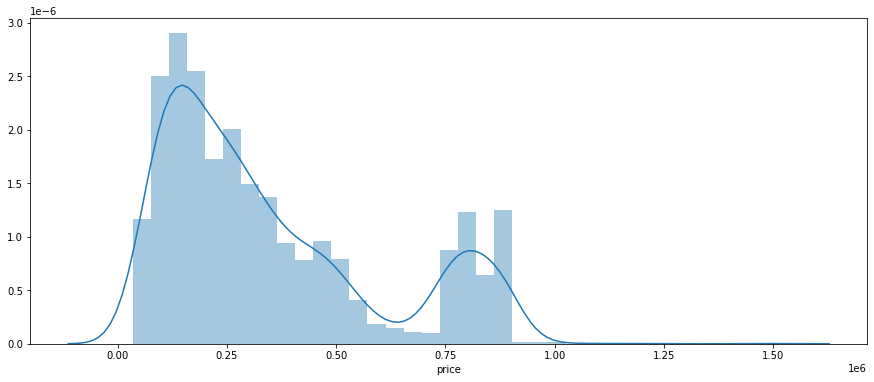

In [4]:
sb.distplot(df.price)

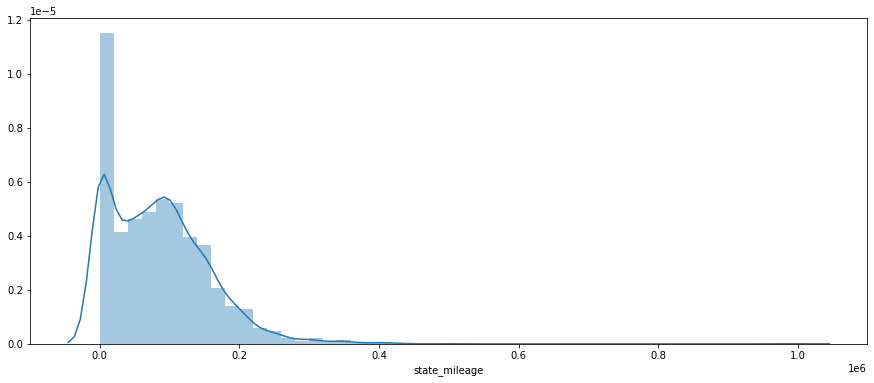

In [5]:
sb.distplot(df.state_mileage)

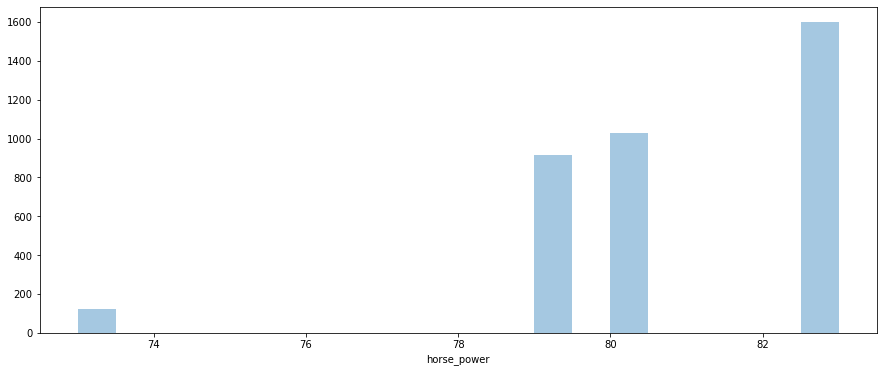

In [7]:
sb.distplot(df.horse_power, kde=False, bins=20)

In [24]:
m = folium.Map(location=[70.5236, 105.6750],
               zoom_start=3
              )

for i in df.index:
    folium.Circle( (df.seller_coords[i][0], df.seller_coords[i][1]), 
                  radius=500,
                  tooltip=df.price[i],
                  opacity=50,
                  fill=True,
                  color=f'#{df.color_hex[i]}').add_to(m)
m